开始加载电池数据...
加载数据集 CS2_35 ...
加载 dataset/CS2_35\CS2_35_10_15_10.xlsx ...
加载 dataset/CS2_35\CS2_35_10_22_10.xlsx ...
加载 dataset/CS2_35\CS2_35_10_29_10.xlsx ...
加载 dataset/CS2_35\CS2_35_11_01_10.xlsx ...
加载 dataset/CS2_35\CS2_35_11_08_10.xlsx ...
加载 dataset/CS2_35\CS2_35_11_23_10.xlsx ...
加载 dataset/CS2_35\CS2_35_11_24_10.xlsx ...
加载 dataset/CS2_35\CS2_35_12_06_10.xlsx ...
加载 dataset/CS2_35\CS2_35_12_13_10.xlsx ...
加载 dataset/CS2_35\CS2_35_12_20_10.xlsx ...
加载 dataset/CS2_35\CS2_35_12_23_10.xlsx ...
加载 dataset/CS2_35\CS2_35_1_10_11.xlsx ...
加载 dataset/CS2_35\CS2_35_1_18_11.xlsx ...
加载 dataset/CS2_35\CS2_35_1_24_11.xlsx ...
加载 dataset/CS2_35\CS2_35_1_28_11.xlsx ...
加载 dataset/CS2_35\CS2_35_2_10_11.xlsx ...
加载 dataset/CS2_35\CS2_35_2_4_11.xlsx ...
加载 dataset/CS2_35\CS2_35_8_17_10.xlsx ...
加载 dataset/CS2_35\CS2_35_8_18_10.xlsx ...
加载 dataset/CS2_35\CS2_35_8_19_10.xlsx ...
加载 dataset/CS2_35\CS2_35_8_30_10.xlsx ...
加载 dataset/CS2_35\CS2_35_9_21_10.xlsx ...
加载 dataset/CS2_35\CS2_35_9_30_10.xlsx

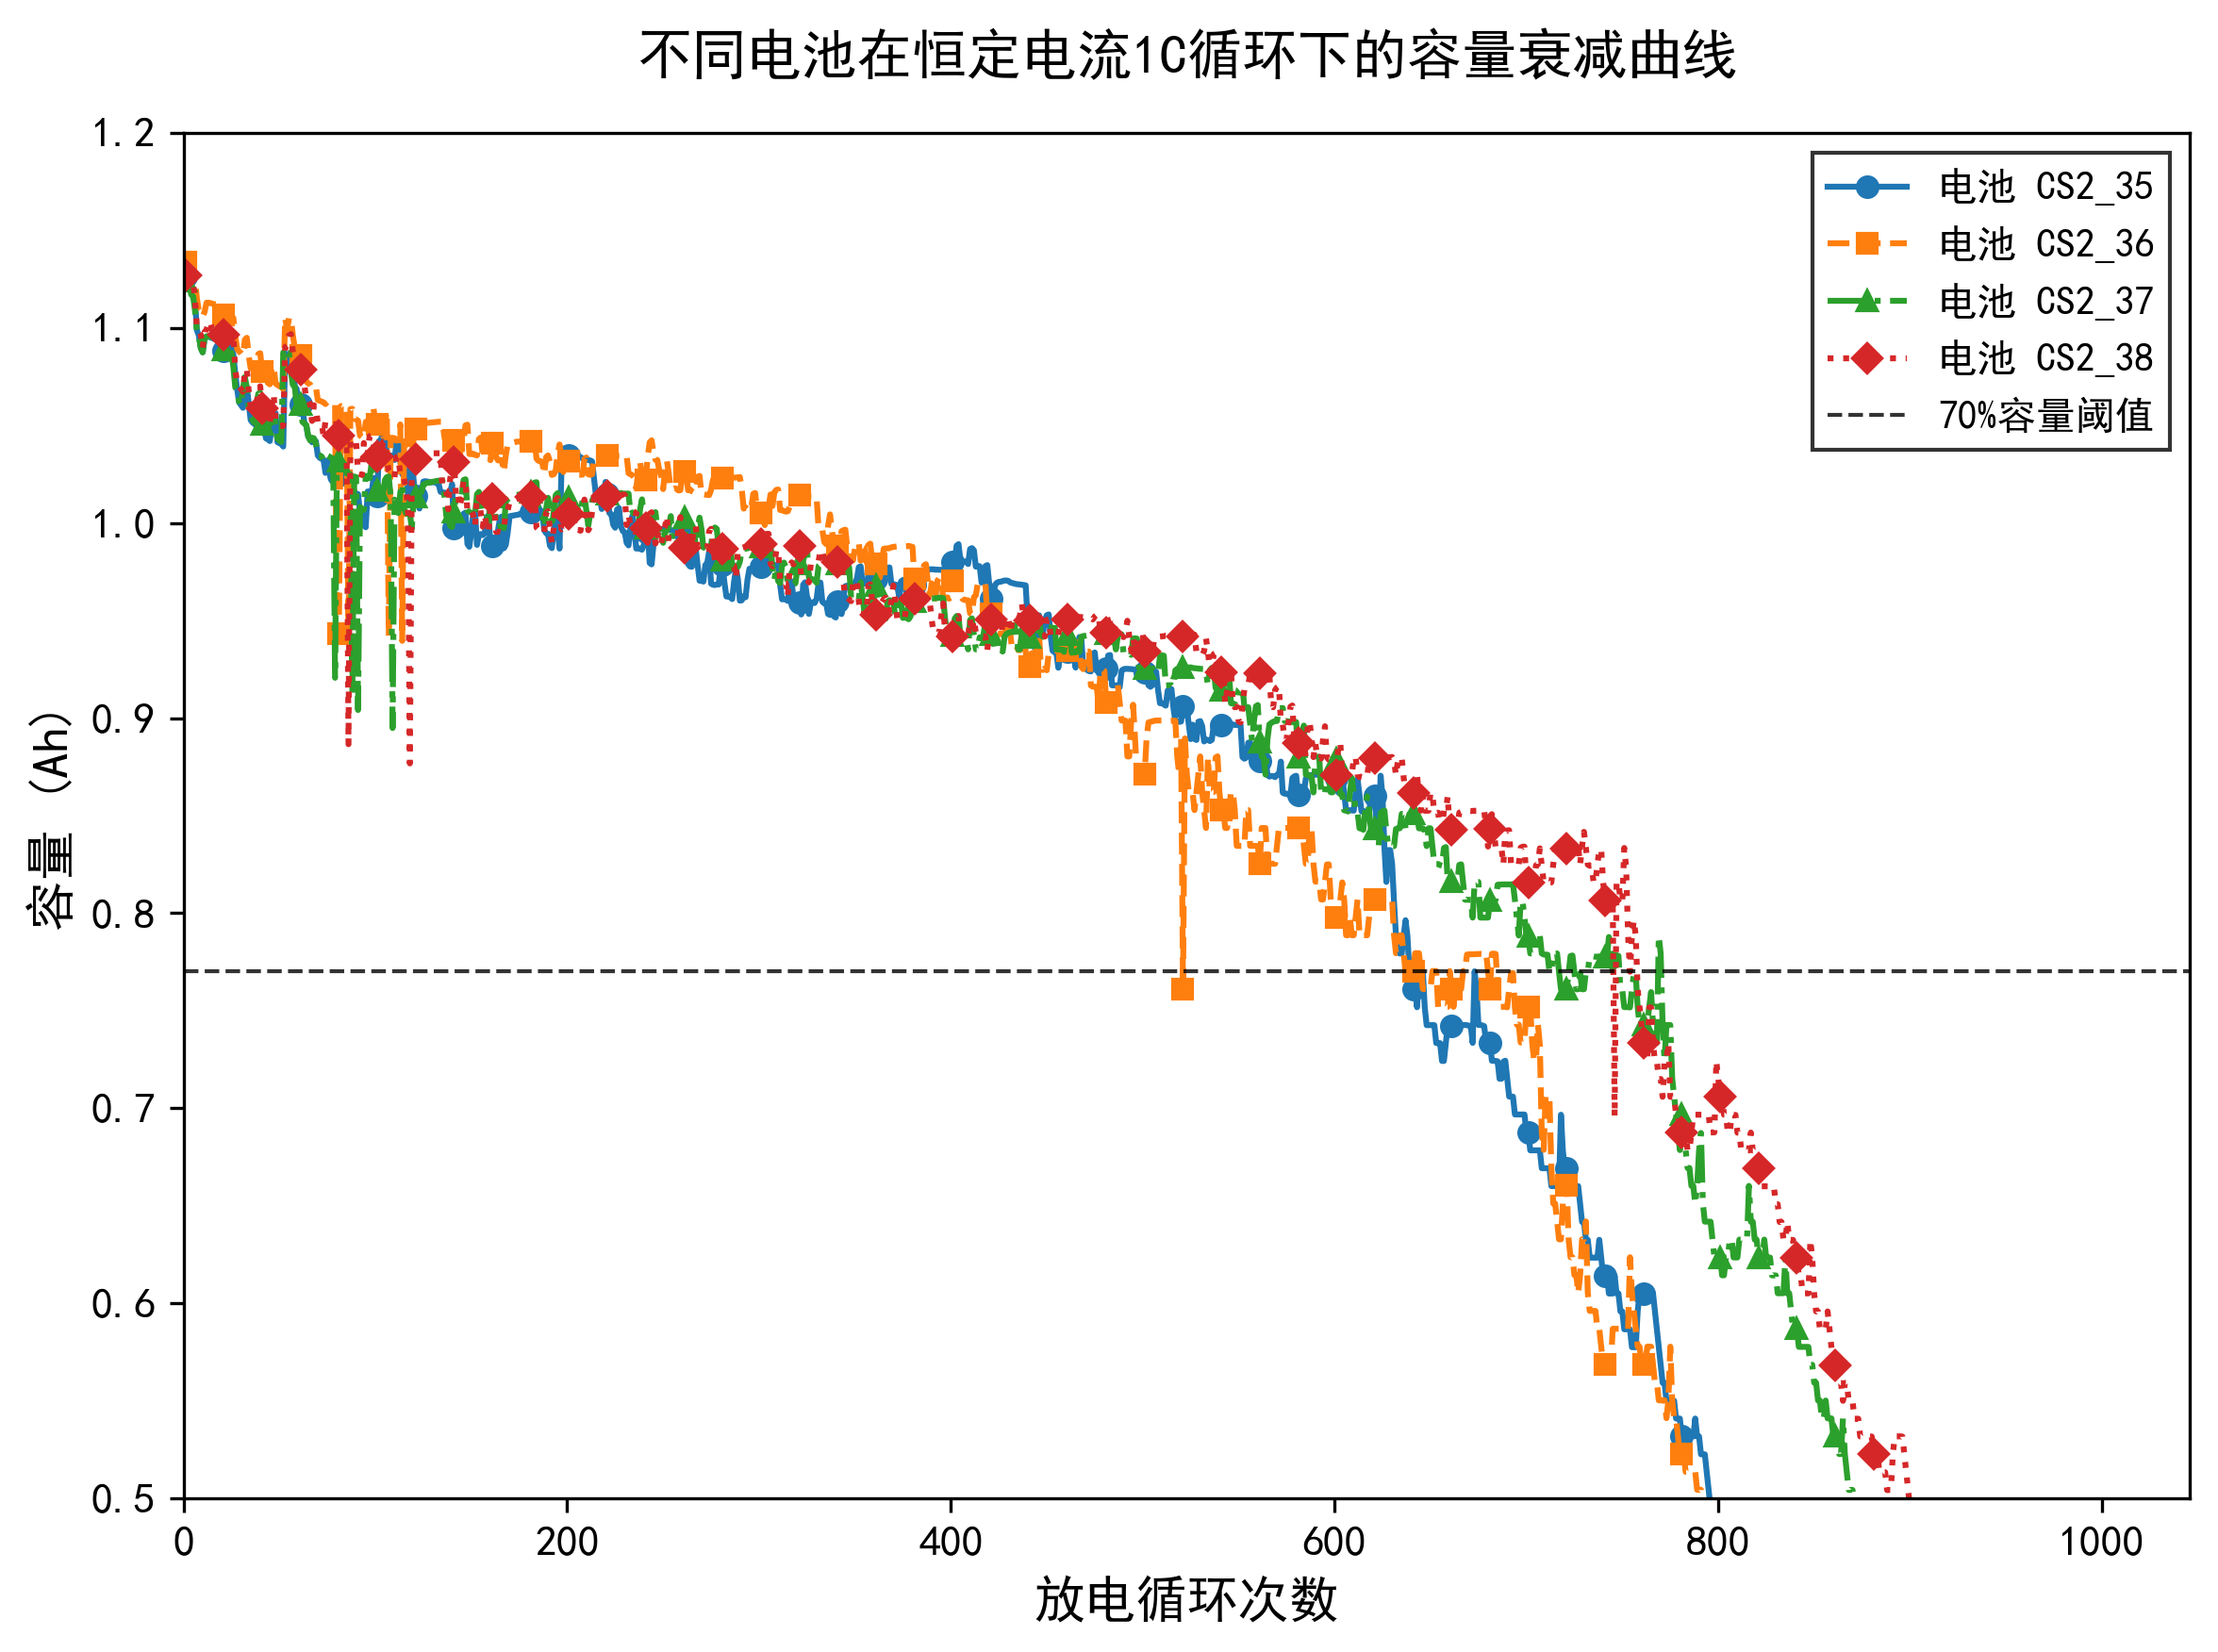

容量衰减曲线已保存为 'capacity_degradation_curve.png'
开始相关系数分析...
计算整体相关系数矩阵...


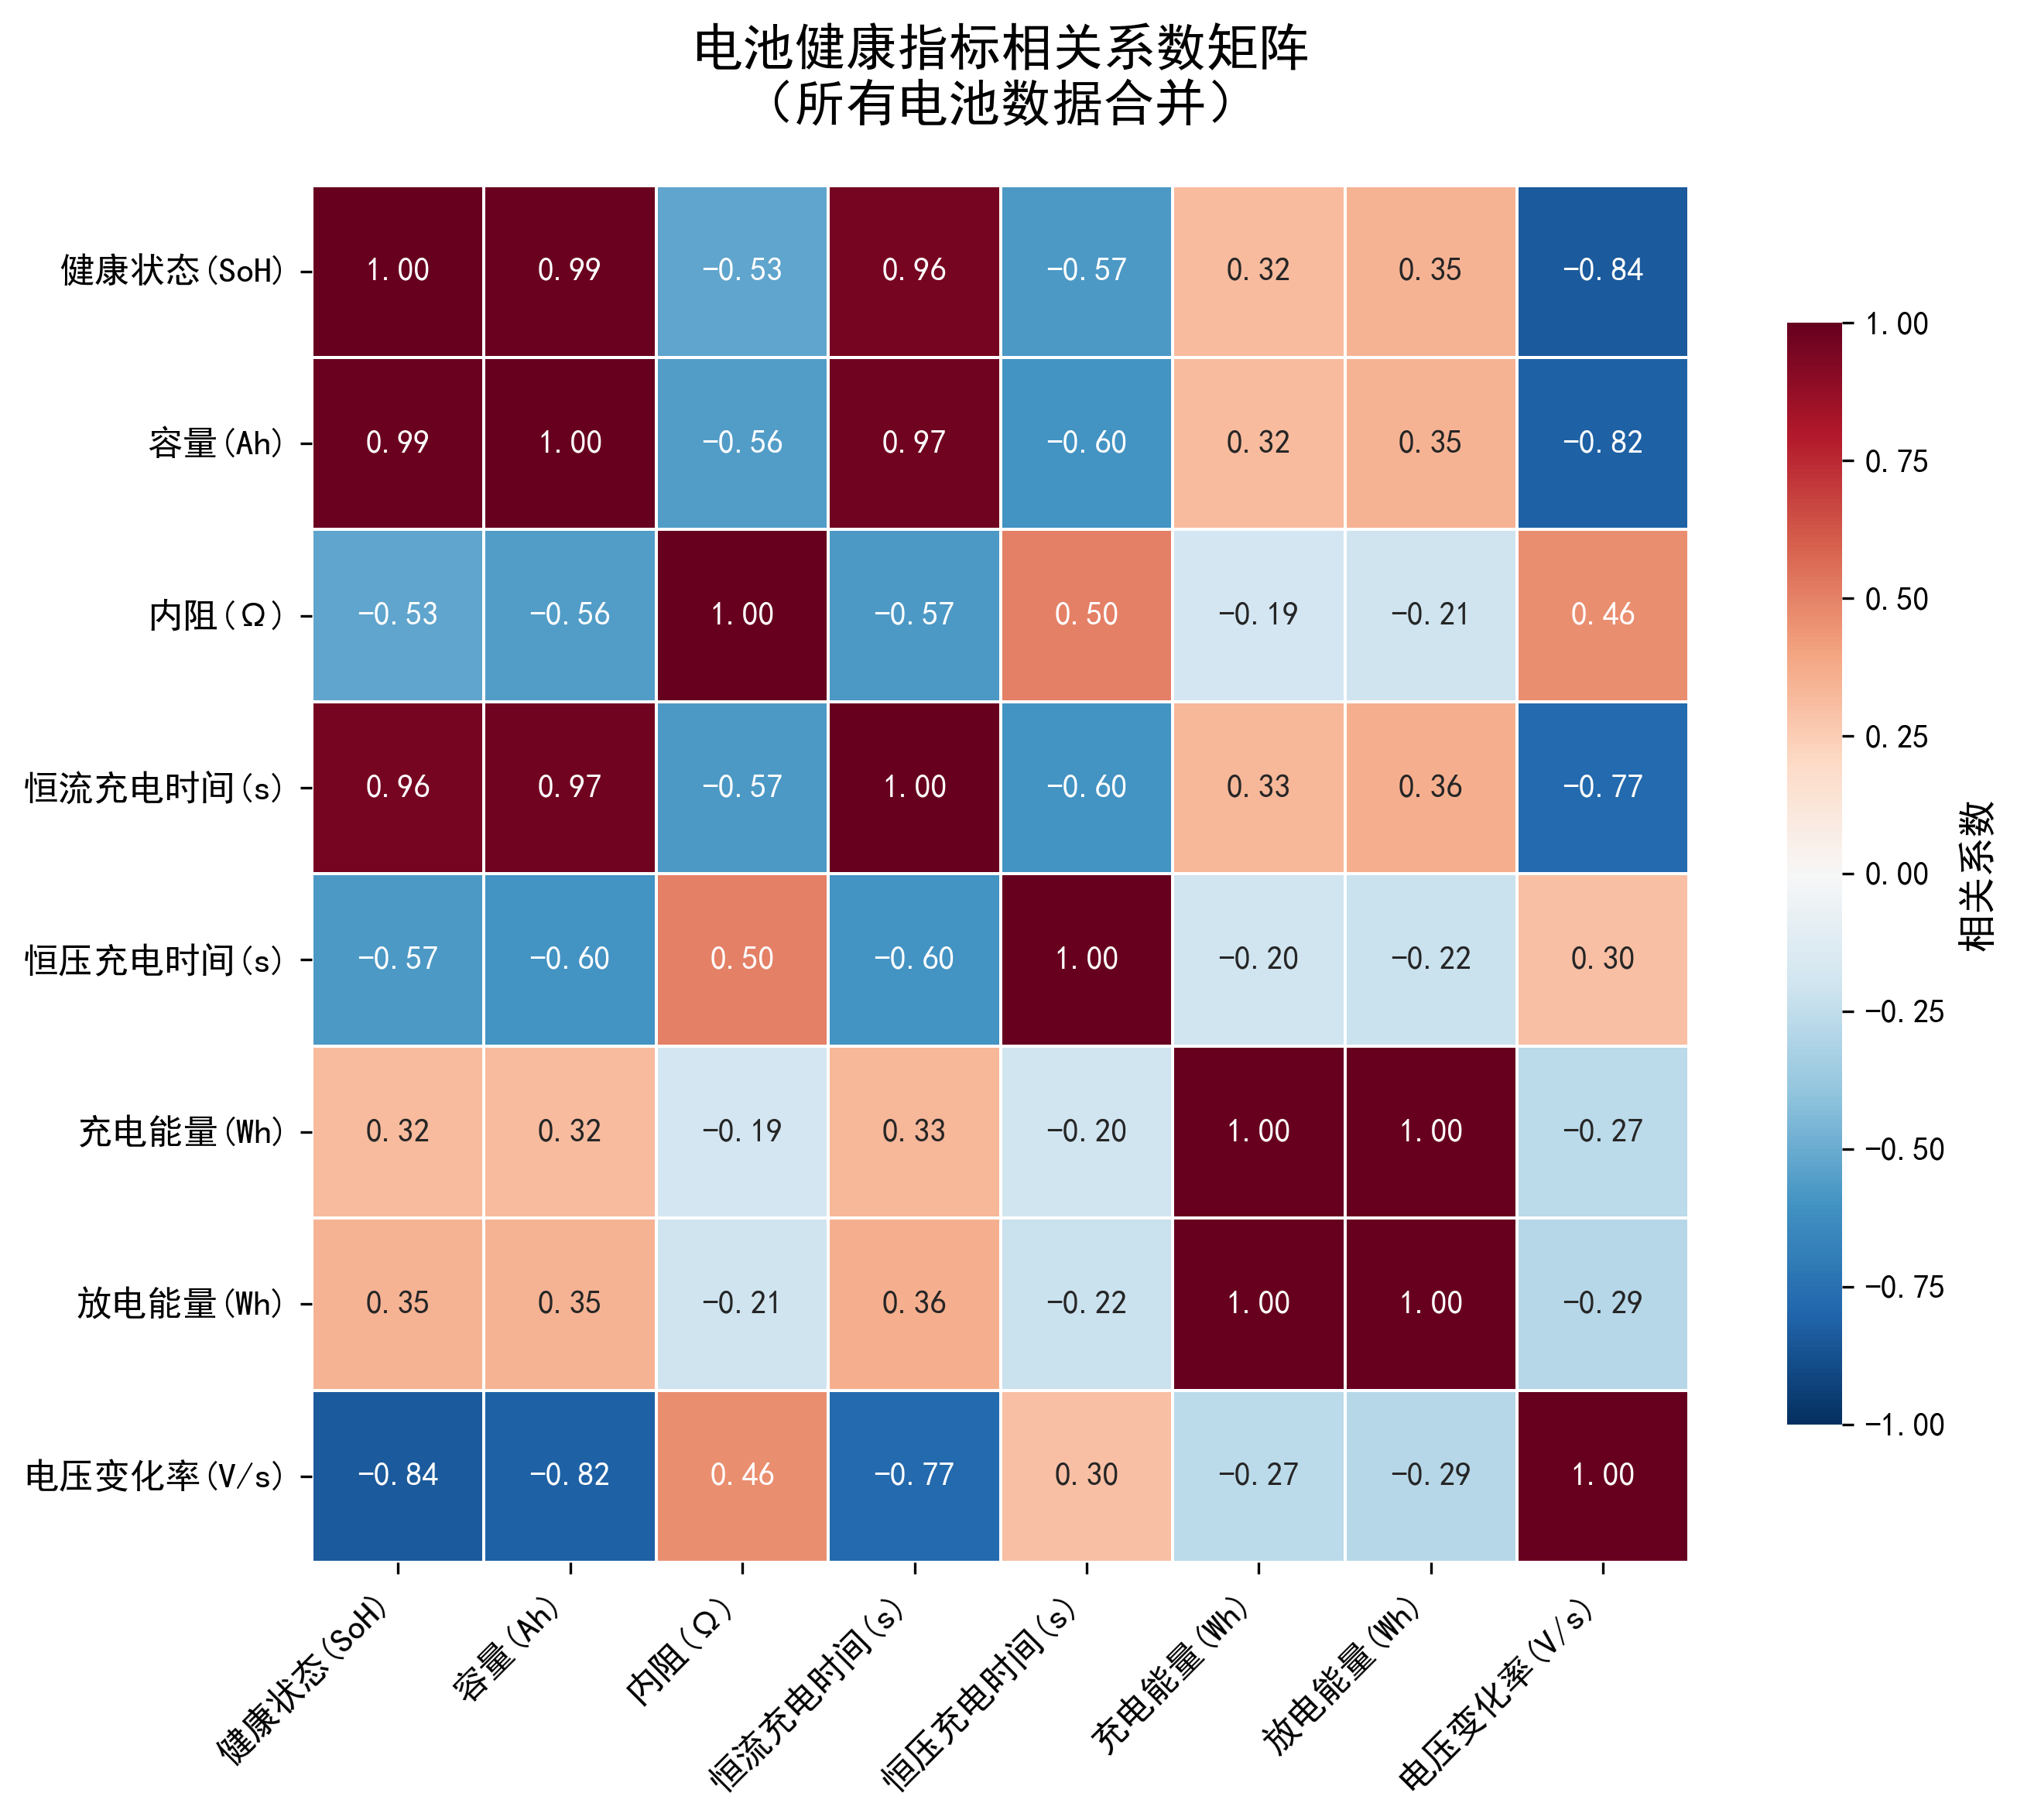

相关系数热力图已保存为 'correlation_heatmap.png'

=== 关键发现总结 ===
各特征与健康状态(SoH)的相关系数（按绝对值排序）:
  健康状态(SoH)            :  1.0000
  容量(Ah)               :  0.9918
  恒流充电时间(s)            :  0.9605
  电压变化率(V/s)           : -0.8392
  恒压充电时间(s)            : -0.5707
  内阻(Ω)                : -0.5271
  放电能量(Wh)             :  0.3460
  充电能量(Wh)             :  0.3179

所有分析完成！


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import seaborn as sns

# 设置中文字体（确保系统中存在这些字体）
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']  # 中文支持
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
plt.rcParams['font.size'] = 12                # 全局字体大小

# 设置高分辨率（适用于期刊论文）
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 600

def drop_outlier(array, count, bins):
    """去除异常值函数"""
    index = []
    range_ = np.arange(1, count, bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max, th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

# 电池列表和数据加载
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
dir_path = 'dataset/'
Battery = {}

print("开始加载电池数据...")
for name in Battery_list:
    print('加载数据集 ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = []
    for p in path:
        df = pd.read_excel(p, sheet_name=1)
        print('加载 ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    charge_energy = []
    discharge_energy = []
    dV_dt = []
    
    for p in path_sorted:
        df = pd.read_excel(p, sheet_name=1)
        print('加载 ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            # Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2) | (df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            # CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)']) - np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)']) - np.min(df_cv['Test_Time(s)']))

            # Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if len(list(d_c)) != 0:
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff * d_c / 3600  # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1 * discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                
                # 新增特征提取
                # 充放电能量
                charge_energy.append(np.max(df_c['Charge_Energy(Wh)']) if 'Charge_Energy(Wh)' in df_c.columns else 0)
                discharge_energy.append(np.max(df_d['Discharge_Energy(Wh)']) if 'Discharge_Energy(Wh)' in df_d.columns else 0)
                
                # 电压变化率 (dV/dt)
                if len(d_v) > 1:
                    voltage_diff = np.diff(list(d_v))
                    time_diff = np.diff(list(d_t))
                    dV_dt.append(np.mean(np.abs(voltage_diff / time_diff)) if np.any(time_diff) else 0)
                else:
                    dV_dt.append(0)
                
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    charge_energy = np.array(charge_energy)
    discharge_energy = np.array(discharge_energy)
    dV_dt = np.array(dV_dt)
    
    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({
        'cycle': np.linspace(1, idx.shape[0], idx.shape[0]),
        'capacity': discharge_capacities[idx],
        'SoH': health_indicator[idx],
        'resistance': internal_resistance[idx],
        'CCCT': CCCT[idx],
        'CVCT': CVCT[idx],
        'charge_energy': charge_energy[idx],
        'discharge_energy': discharge_energy[idx],
        'dV_dt': dV_dt[idx],
        'coulombic_efficiency': discharge_energy[idx] / (charge_energy[idx] + 1e-6),
        'energy_density': discharge_energy[idx] / (discharge_capacities[idx] + 1e-6)
    })
    Battery[name] = df_result

print("数据加载完成！")

# ===============================================
# 1. 绘制容量衰减曲线（高分辨率，中文标签）
# ===============================================
print("绘制容量衰减曲线...")

# 创建高分辨率图形
fig, ax = plt.subplots(1, figsize=(8, 6), dpi=300)

# 设置颜色和样式
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, (name, style) in enumerate(zip(Battery_list, line_styles)):
    battery = Battery[name]
    ax.plot(battery['cycle'], battery['capacity'], 
            color=colors[i % len(colors)],
            linestyle=style,
            marker=markers[i % len(markers)],
            markevery=20,
            markersize=5,
            linewidth=1.5,
            label=f'电池 {name}')

# 添加容量阈值线
ax.axhline(y=1.1*0.7, color='k', linestyle='--', alpha=0.8, linewidth=1, label='70%容量阈值')

# 设置标签和标题
ax.set_xlabel('放电循环次数', fontsize=13, fontweight='bold')
ax.set_ylabel('容量 (Ah)', fontsize=13, fontweight='bold')
ax.set_title('不同电池在恒定电流1C循环下的容量衰减曲线', fontsize=14, fontweight='bold', pad=15)

# 设置图例
ax.legend(frameon=True, fancybox=False, edgecolor='black', fontsize=10, loc='upper right')

# 设置坐标轴
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_xlim(0, None)
ax.set_ylim(0.5, 1.2)

# 添加网格线（细线，不显眼）
ax.grid(False)

# 紧凑布局并显示
plt.tight_layout()
plt.show()

# 保存为高分辨率图片
fig.savefig('capacity_degradation_curve.png', dpi=600, bbox_inches='tight', facecolor='white')
print("容量衰减曲线已保存为 'capacity_degradation_curve.png'")

# ===============================================
# 2. 相关系数热力图（高分辨率，中文标签）
# ===============================================
print("开始相关系数分析...")

# 收集所有电池的数据
all_data = []
for name in Battery_list:
    battery_data = Battery[name].copy()
    battery_data['Battery'] = name
    all_data.append(battery_data)

# 合并所有电池数据
combined_data = pd.concat(all_data, ignore_index=True)

# 使用指定的特征列
feature_columns = [
    'SoH', 
    'capacity', 
    'resistance', 
    'CCCT', 
    'CVCT',
    'charge_energy',
    'discharge_energy',
    'dV_dt'
]

# 中文特征名称
feature_names_chinese = [
    '健康状态(SoH)', 
    '容量(Ah)', 
    '内阻(Ω)', 
    '恒流充电时间(s)', 
    '恒压充电时间(s)',
    '充电能量(Wh)',
    '放电能量(Wh)',
    '电压变化率(V/s)'
]

print("计算整体相关系数矩阵...")
# 计算皮尔逊相关系数矩阵
correlation_matrix = combined_data[feature_columns].corr(method='pearson')

# 创建高分辨率热力图
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 8), dpi=300)

# 使用seaborn绘制热力图
heatmap = sns.heatmap(correlation_matrix, 
                      ax=ax2,
                      annot=True, 
                      cmap='RdBu_r',  # 红色-蓝色渐变色
                      center=0,
                      square=True, 
                      fmt='.2f',      # 保留两位小数
                      cbar_kws={'shrink': 0.8, 'label': '相关系数'},
                      annot_kws={'size': 10, 'weight': 'bold'},
                      linewidths=0.5,
                      linecolor='white',
                      xticklabels=feature_names_chinese,
                      yticklabels=feature_names_chinese,
                      vmin=-1, vmax=1)

# 设置标题和标签
ax2.set_title('电池健康指标相关系数矩阵\n（所有电池数据合并）', 
              fontsize=16, fontweight='bold', pad=20)

# 设置坐标轴标签旋转
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)

# 调整颜色条标签
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.ax.set_ylabel('相关系数', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# 保存为高分辨率图片
fig2.savefig('correlation_heatmap.png', dpi=600, bbox_inches='tight', facecolor='white')
print("相关系数热力图已保存为 'correlation_heatmap.png'")

# ===============================================
# 输出关键发现
# ===============================================
print("\n=== 关键发现总结 ===")
soh_correlations = correlation_matrix['SoH'].sort_values(key=abs, ascending=False)
print("各特征与健康状态(SoH)的相关系数（按绝对值排序）:")
for feature, corr in soh_correlations.items():
    feature_name = feature_names_chinese[feature_columns.index(feature)]
    print(f"  {feature_name:20} : {corr:7.4f}")

print("\n所有分析完成！")